In [123]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Laoding data from CSV
casualtyData = pd.read_csv("Data/number-of-deaths-and-serious-inj.csv")

# Giving columns more convinient names
casualtyData.columns = ["month", "casualties", "lawEnacted"]

# Remove last row since it only contains a note, not data.
casualtyData.drop(casualtyData.index[-1], inplace=True)

casualtyData.index = pd.to_datetime(casualtyData.month).values

casualtyData.drop("month", axis=1, inplace=True)

casualtyData.sample(10)

,casualties,lawEnacted
1972-06-01,1853.0,0.0
1983-10-01,1487.0,1.0
1973-10-01,2080.0,0.0
1979-02-01,1445.0,0.0
1981-03-01,1542.0,0.0
1982-09-01,1594.0,0.0
1978-12-01,2262.0,0.0
1977-09-01,1515.0,0.0
1974-11-01,2092.0,0.0
1973-07-01,2012.0,0.0


In [124]:
law_start = casualtyData[casualtyData.lawEnacted == 1].index[0]
months = pd.get_dummies(casualtyData.index.month)
months.index = casualtyData.index
casualtyData = casualtyData.join(months)

casualtyData.sample(5)

,casualties,lawEnacted,1,2,3,4,5,6,7,8,9,10,11,12
1969-02-01,1508.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1983-09-01,1427.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1984-01-01,1357.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-01-01,1687.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981-05-01,1522.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


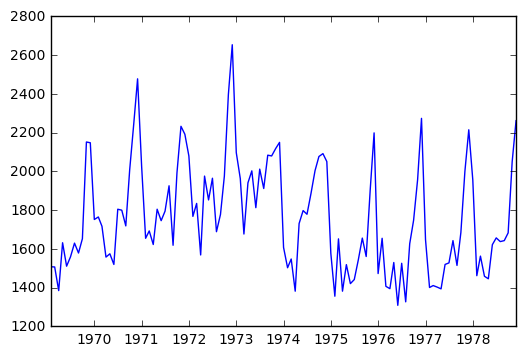

In [125]:
prelaw = casualtyData[casualtyData.lawEnacted==0.0]

plt.plot(prelaw[1:120].casualties)
plt.show()

In [126]:
nSteps = 40
train = prelaw[0:(-nSteps-1)]
test = prelaw[(-nSteps-1):-1]

/Users/Abe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Abe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Abe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Abe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Abe/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

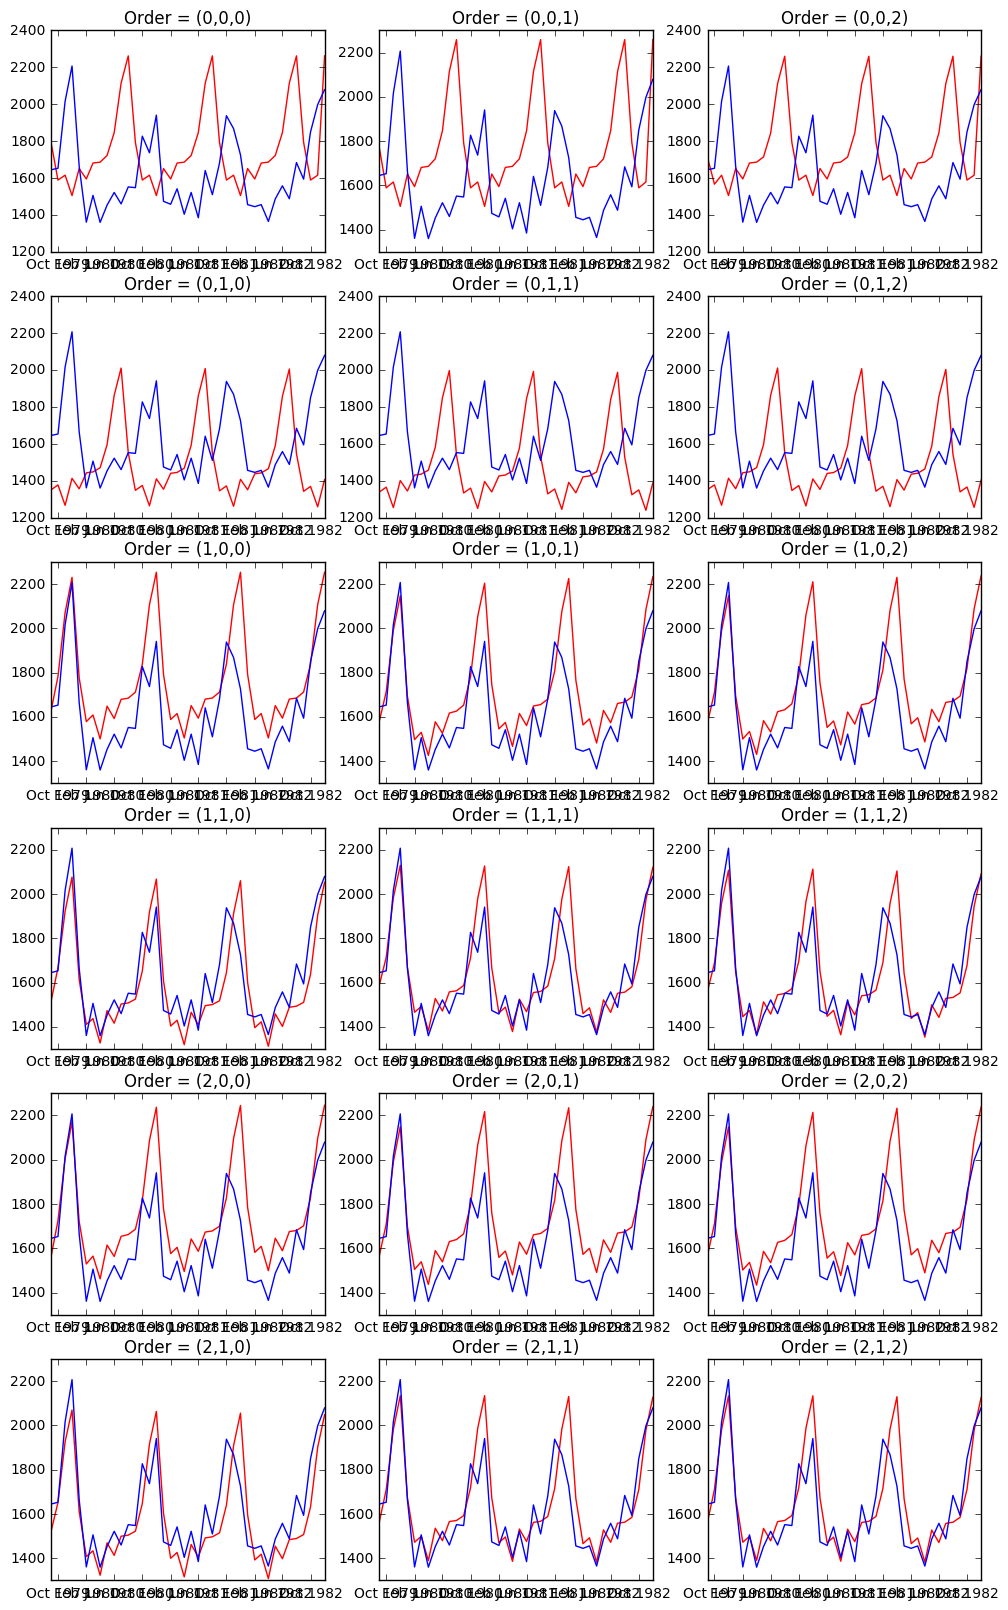

In [127]:
error = []
p=1

plt.figure(0, figsize=[12,20])

for a in range(3):
    for i in range(2):
        for m in range(3):
            model = sm.tsa.ARIMA(endog=train.casualties, 
              order=(a,i,m), 
              exog=train[np.arange(1,13)]).fit()

            forcast = model.forecast(steps=nSteps, exog=test[np.arange(1,13)])
            
            error.append([a,i,m, np.power((forcast[0] - test.casualties),2).sum()])
            
            plt.subplot(6,3,p); p+=1
            plt.title("Order = ({},{},{})".format(a,i,m))
            plt.plot(pd.DataFrame({"forcast":forcast[0]}, index=test.index), "r", label="Forcast")
            plt.plot(test.casualties, "b", label="Test Set")

plt.show()

In [128]:
forcastDF = pd.DataFrame({"casualties":forcast[0], 
                          "CI_low":forcast[2][:,0], 
                          "CI_hi":forcast[2][:,1]}, index=test.index[0:nSteps])

In [129]:
error.append([a,i,m, np.power((forcastDF.casualties - test.casualties),2).sum()])

In [130]:
errorDF = pd.DataFrame({"AR":map(lambda x: x[0],error),
                        "In":map(lambda x: x[1],error),
                        "MA":map(lambda x: x[2],error),
                        "error":map(lambda x: x[3],error)
                       })

In [131]:
errorDF.sort_values(by="error")

,AR,In,MA,error
11,1,1,2,5.309724e+05
10,1,1,1,5.392988e+05
18,2,1,2,5.562541e+05
17,2,1,2,5.562541e+05
16,2,1,1,5.581194e+05
9,1,1,0,5.911172e+05
15,2,1,0,6.012388e+05
7,1,0,1,9.553017e+05
8,1,0,2,1.000652e+06
14,2,0,2,1.023661e+06


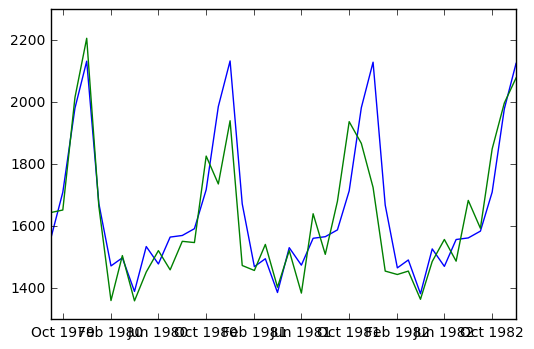

In [132]:
plt.plot(forcastDF.casualties)
plt.plot(test.casualties)
plt.show()

In [133]:
plt.show()